In [70]:
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install nltk
!pip install seaborn
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
res = []

with open("./corpus__fasttext.txt","r") as f :
    for line in f:
        label, sentence = line.split(" ",1)   
        res.append((label.replace("__label__",""), sentence))    
        
df = pd.DataFrame(res,columns=["label","text"])

df

,label,text
0,radical,"""Êtes-vous prêt à faire rendre des comptes à ..."
1,radical,"""Inapproprié [malade] pour vous ? Normal pour ..."
2,radical,"""Les termes «Cabale» et «État profond» font ré..."
3,radical,"""Le pire, c'est qu'ils adorent Satan et commet..."
4,radical,"""Symboles et logos utilisés par les pédophiles..."
...,...,...
1470,non_radical,"""Les crises économique et terroriste de 2008 e..."
1471,non_radical,"""à la différence de la crise financière de 200..."
1472,non_radical,"""Dans l’instant, la photographie de la situati..."
1473,non_radical,"""Ce recul relativement faible du revenu des mé..."


In [73]:
df_radical = df.groupby('label').get_group('radical')
df_non_radical = df.groupby('label').get_group('non_radical')

#Permet d'avoir les meme proportion pour le df_training et le df_validation
part1_rad, part2_rad = train_test_split(df_radical, test_size=0.2, random_state=13)
part1_non_rad, part2_non_rad = train_test_split(df_non_radical, test_size=0.2, random_state=13)

df_train =  pd.merge(part1_rad, part1_non_rad, how='outer')
df_test =  pd.merge(part2_rad, part2_non_rad, how='outer')

In [74]:
label_binarizer = LabelBinarizer()

# Les colonnes text et polarity contiennent le texte et les labels respectivement
sentences_train = df_train['text'].tolist()
y_train = label_binarizer.fit_transform(df_train['label'].tolist())

sentences_test = df_test['text'].tolist()
y_test = label_binarizer.fit_transform(df_test['label'].tolist())

# Convertir les labels en tableau numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Créer un tokenizer et ajuster-le aux données
tokenizer = Tokenizer(num_words=300, lower=True)
tokenizer.fit_on_texts(sentences_train)

# Obtenir la taille du vocabulaire +1 pour le padding
vocab_size = len(tokenizer.word_index) + 1

# Convertir les phrases en séquences numériques
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Définir la longueur maximale des séquences
maxlen = 50

# Ajouter le padding aux séquences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [75]:
embedding_dim = 50

model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/5
19/19 [==============================] - 2s 39ms/step - loss: 0.6801 - accuracy: 0.5864 - val_loss: 0.6752 - val_accuracy: 0.5932
Epoch 2/5
19/19 [==============================] - 1s 31ms/step - loss: 0.6717 - accuracy: 0.5932 - val_loss: 0.6754 - val_accuracy: 0.5932
Epoch 3/5
19/19 [==============================] - 0s 26ms/step - loss: 0.6627 - accuracy: 0.5941 - val_loss: 0.6739 - val_accuracy: 0.5932
Epoch 4/5
19/19 [==============================] - 1s 27ms/step - loss: 0.6530 - accuracy: 0.6000 - val_loss: 0.6743 - val_accuracy: 0.5932
Epoch 5/5
10/10 [==============================] - 0s 10ms/step - loss: 0.6708 - accuracy: 0.5932
Test Score: 0.6707729697227478
Test Accuracy: 0.5932203531265259


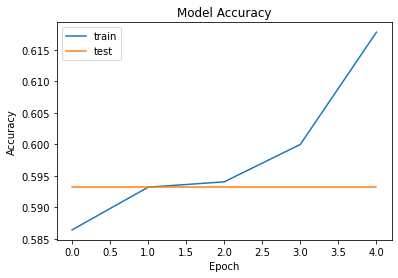

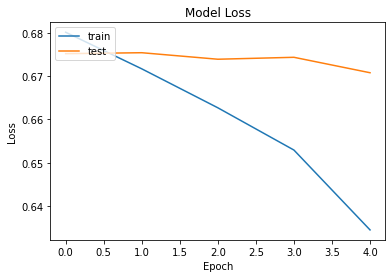

In [76]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = [1 if i >= 0.5 else 0 for i in y_pred ]

# L'entraînement est terminé, évaluons le modèle sur l'ensemble de test
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Plot de la précision et de la perte pour l'ensemble d'entraînement et de validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


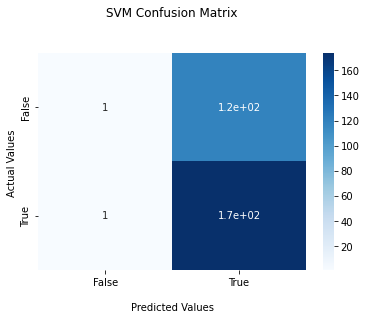

In [77]:
cf_matrix = tf.math.confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('SVM Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()